<a href="https://colab.research.google.com/github/giuliocapecchi/interactive-RAG/blob/main/RAG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Authors: Giulio Capecchi, Giacomo Moro, Jacopo Niccolai, Andrea Ruggieri

Master of Science in Artificial Intelligence and Data Engineering

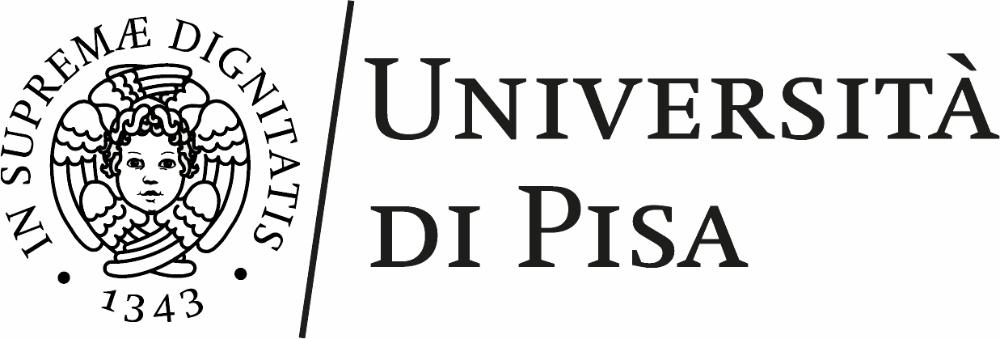

# Retrieval-Augmented Generation (RAG) for *Information Retrieval* Query Answering

This project implements a **Retrieval-Augmented Generation (RAG)** system, a modern technique that integrates document retrieval and answer generation. The RAG approach enhances the performance of large language models (LLMs) by incorporating external information to improve the model's ability to answer queries outside its original training data. This is especially beneficial for businesses or single users that cannot afford to build a ChatGPT-like LLM *from scratch*. RAG provides a faster and more efficient alternative than re-training, as it tries to expand the model knowledge by simply providing relevant documents as data sources to the user's queries.

**The use cases of RAGs** include:
- Chatbots
- Document-based question answering systems
- Legal and technical document summarization
- many more

In this project, we will develop a **chatbot-like** system where users can upload PDF documents and ask the LLM about them. Particularly, we tried to balance good performances with the necessity to utilize *light* (computationally speaking) models. The results were in the end quite satisfying.


The proposed pipeline will:

1. Split the documents into smaller chunks (with special handling for *mathematical formulas*).
2. Embed these chunks using a model from Hugging Face (`cde-small-v1`).
3. Initialize a (quantized) local copy of `LLaMA 3.2 3B` for answer generation.
4. Provide access to the model trough a `Gradio` interface.

More details will be present in their respective sections.


In the following, we will delve into the technical details and results obtained from implementing this pipeline, including performance analysis and the metrics used to evaluate the system's effectiveness.

---


## PDF Preprocessing and Documents Creations

One of the critical challenges in preprocessing documents for the implementation of a RAG system is ensuring accurate and efficient data extraction while maintaining contextual integrity. To address this, we developed a pipeline that tries to handle various aspects of document preprocessing, leveraging open-source tools to achieve good results.

The first phase regards the preprocessing and splitting of the chosen PDF file. To accomplish this, we propose a hybrid approach that combines two tools:  
- [**Unstructured**](https://github.com/Unstructured-IO): An open-source tool for converting unstructured data into **structured** outputs.   
- [**Nougat**](https://github.com/facebookresearch/nougat  ): A Transformer-based OCR model designed to simplify the conversion of complex content into a machine-readable format.   

The pipeline integrates these as follows:  
1. **Document Parsing**: Using `Unstructured`'s partition function, we extracted elements characterized by type and content. This allowed us to:  
   * Filter irrelevant or meaningless elements.  
   * identify **mathematical formulas**, since they will have a special type
   * Translate elements into a **dataframe with columns for Type and Value** for easier handling.  

2. **Enhanced Content Extraction**: Pages requiring additional attention (e.g., those with complex elements such as formulas) were processed using `Nougat`. This converts them into text formatted in Markdown.

By combining the strengths of `Unstructured` and `Nougat`, this approach enables the creation of good quality, structured document representations while addressing challenges like text cleaning, splitting, and chunking.

### Computational Considerations and Simpler Alternatives

These preprocessing steps, particularly those involving splitting and structuring complex documents, are computationally demanding. This pipeline is most effective for **academic paper-style documents**, which often feature intricate structures or a mix of diverse content types, and are often just a few pages long.

For documents primarily composed of simple text, **lighter and faster alternatives** exist. For instance, the [Text Splitters](https://python.langchain.com/docs/concepts/text_splitters/) provided by LangChain offer a simpler, yet effective, solution for text-based document splitting, significantly reducing processing time and resource usage.

Let's dive into the implementation. Let's start by installing required libraries.

In [64]:
%pip install -qqq torch gdown huggingface_hub python-dotenv pymupdf tiktoken ir_measures rank_bm25 python-Levenshtein nltk tqdm unidecode gradio bitsandbytes seaborn unstructured[pdf] --progress-bar off

Note: you may need to restart the kernel to use updated packages.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
nougat-ocr 0.1.17 requires timm==0.5.4, but you have timm 1.0.12 which is incompatible.


### Installing Additional Required Libraries

On Colab, the installations above are sufficient. However, on **Windows** and **macOS**, additional steps are required to install libraries necessary for both Unstructured and Nougat:

- **Poppler**: a PDF rendering library.  
- **Tesseract**: an open-source OCR engine.


#### **Steps for Windows**
The easiest way to install the required libraries on Windows is via Conda (assuming Conda is installed):

1. **Install the required packages**:
    ```bash
    %conda install -c conda-forge poppler tesseract -y
    %pip install -q python-magic-bin==0.4.14
    ```

2. **Add Tesseract to the system PATH**:
    Use the following Python code to set up the `TESSDATA_PREFIX` environment variable:

    ```python
    import os, sys

    # Get the path of the current Conda environment
    conda_env_path = os.path.dirname(sys.executable)
    tessdata_path = os.path.join(conda_env_path, "share", "tessdata") # the necessary files should be here

    # Set the TESSDATA_PREFIX environment variable
    os.environ["TESSDATA_PREFIX"] = os.path.join(conda_env_path, "share")
    print("TESSDATA_PREFIX:", os.environ["TESSDATA_PREFIX"])

    # Verify the tessdata directory
    if os.path.exists(tessdata_path):
        print(f"Tessdata directory found: {tessdata_path}")
    else:
        print(f"Tessdata directory not found: {tessdata_path}")
    ```

#### **Steps for macOS**
On macOS, installation is simpler. Use the following command to install the required libraries (using `brew`):

1. **Install the required packages**:
    ```bash
    brew install poppler tesseract
    ```

2. **Verify the installation**:
    Check if Tesseract is properly installed by running:
    ```bash
    tesseract --version
    ```


As said, this approach serves as an enhancement to the RAG pipeline, enabling more accurate extraction from PDFs, particularly for elements like mathematical formulas in scientific papers. However, it is not mandatory; if the PDF contains mostly plain text, a simpler chunking method may be sufficient and more straightforward.

### Downloading the Selected PDF for Analysis

In this notebook, we will use slides from our *Multimedia and Information Retrieval* course. These slides present a challenging objective due to their inclusion of complex mathematical formulas, making accurate parsing a non-trivial task. In the next cell we will download the chosen PDF. You are free to select any PDF of your preference; however, keep in mind that the evaluation phase will of course vary depending on the content of the document. 

--- 
> **Note:** To speed up execution, we’ll also download the `elements.pkl` file to bypass some expensive processing (which would otherwise take approximately *~10-15 minutes* for ~300 pages).

In [65]:
import os
import gdown


PDF_NAME = "Information Retrieval Slides.pdf"
if os.path.exists(PDF_NAME):
    print(f"File {PDF_NAME} already exists.")
else:
    # save locally from https://drive.google.com/file/d/1xUA6_ZBJzWGF7kWpM1YZTK3R1siYg1qY/view?usp=drive_link
    gdown.download(id="1xUA6_ZBJzWGF7kWpM1YZTK3R1siYg1qY", output=PDF_NAME, quiet=False)

    # download of pickled elements to speed up the execution
    gdown.download(id="17eXYgmiTL9-f9F5vIT5j7QffHIu_QwuN", output="elements.pkl", quiet=False)

File Information Retrieval Slides.pdf already exists.


## PDF Partitioning with Unstructured

<style>
    img {
        border-radius: 15px;
    }
    .center {
        display: flex;
        justify-content: center;
    }
    .center img {
        width: 50%;
   }
</style>

<div class="center">
        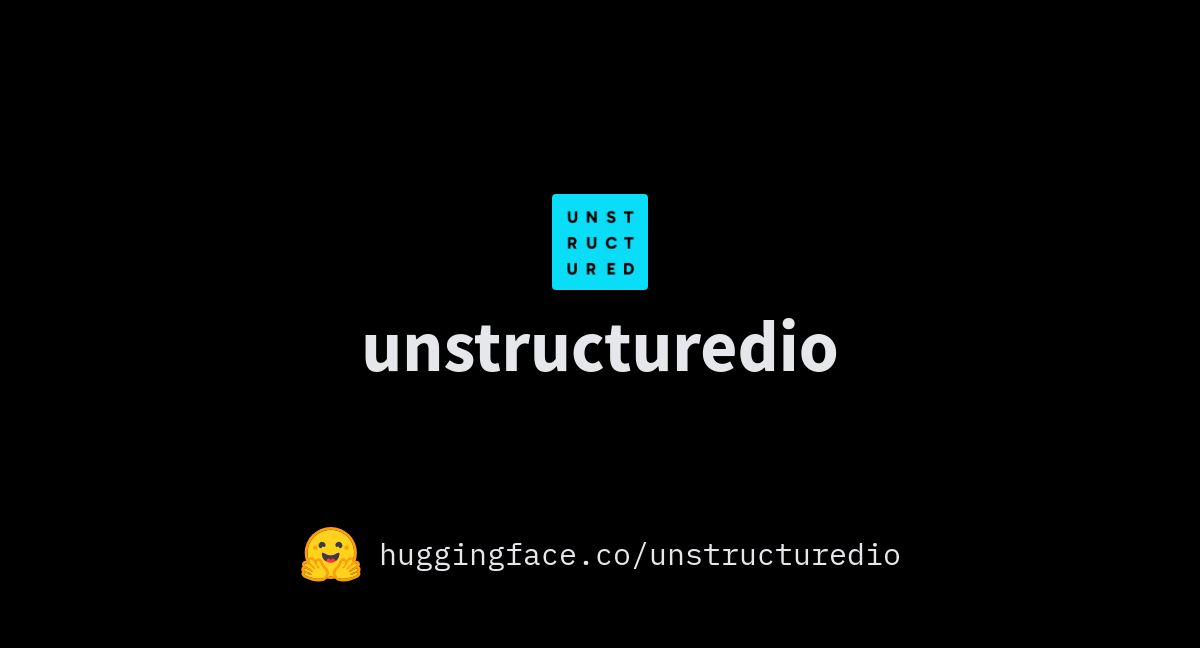
</div>


This tool processes the PDF using the `partition` function to extract structured elements.

It provides various strategies, but we decide to apply the **`hi_res`** strategy because is highly sensitive and it is recommended if you want obtain precise classifications for document elements. Other ones were `fast` and `ocr_only`, but didn't produce acceptable results. Adopting this strategy, `Unstructured` was able to use the document layout to gain additional information about document elements, in particular it can recognize:

- **Titles** and **Text** (we use them as it is)
- **Formulas** (we further process them)
- **Page Breaks** (fundamental create chuncks)
- **Images** (will be removed)


As said, Unstructured can be computationally quite expensive, especiallt with the `hi_res` strategy; that is why we downloaded `elements.pkl` above, that contains the results produced by Unstructured on the target PDF. In the following cell, set `load_elements_from_pickle = False` to recompute them (takes approximately ~10/15 minutes).

In [66]:
from unstructured.partition.auto import partition
from tqdm import tqdm
import fitz  # PyMuPDF
import pickle


load_elements_from_pickle = True
elements = []

if load_elements_from_pickle:
    # load elements from pickle
    with open('elements.pkl', 'rb') as f:
        elements = pickle.load(f)
else: # process the PDF file
    doc = fitz.open(PDF_NAME)  # open the PDF file
    total_pages = len(doc)

    for page_number in tqdm(range(total_pages), desc="Processing PDF pages"):
        # extract the single page
        temp_doc = fitz.open()
        temp_doc.insert_pdf(doc, from_page=page_number, to_page=page_number)

        # save the page to a temporary file
        temp_page_file = f"temp_page_{page_number}.pdf"
        temp_doc.save(temp_page_file)
        temp_doc.close()

        # apply the partitioning to the page
        page_elements = partition(
            filename=temp_page_file,
            strategy="hi_res",
            skip_infer_table_types=[],
            include_page_breaks=True
        )
        elements.extend(page_elements)  # add the elements to the list
        # finally, delete the temporary file
        os.remove(temp_page_file)

    doc.close()

# print the number of recognized elements
print("Number of recognized elements: " + str(len(elements)) + " in file " + PDF_NAME)

Number of recognized elements: 4486 in file Information Retrieval Slides.pdf


Now store the elements in a pickle file

In [67]:
with open('elements.pkl', 'wb') as f:
    pickle.dump(elements, f)

## Filtering and Analyzing Extracted Elements

Here we build a **dataframe**, creating pairs of **Type** and **Value**, using the elements extracted from the PDF file.

Then we print all the different element's Type recognized.



In [68]:
import pandas as pd

df_elements = pd.DataFrame( [[type(elem), elem.text] for elem in elements], columns=['Type', 'Value'])

# Print all the unique types of elements
print(df_elements['Type'].unique())

[<class 'unstructured.documents.elements.Title'>
 <class 'unstructured.documents.elements.EmailAddress'>
 <class 'unstructured.documents.elements.PageBreak'>
 <class 'unstructured.documents.elements.ListItem'>
 <class 'unstructured.documents.elements.NarrativeText'>
 <class 'unstructured.documents.elements.Image'>
 <class 'unstructured.documents.elements.FigureCaption'>
 <class 'unstructured.documents.elements.Table'>
 <class 'unstructured.documents.elements.Text'>
 <class 'unstructured.documents.elements.Footer'>
 <class 'unstructured.documents.elements.Formula'>
 <class 'unstructured.documents.elements.Header'>]


Next, we clean the dataframe by filtering out elements that are not useful for our pipeline:  
- **Images**: While OCR techniques extract text from images, the resulting content often lacks meaningful context and is not suitable for the language model.  
- **Tables**: Similar to images, the extracted text from tables often loses its structural meaning and context.  
- **Footers** and **Headers**: These typically contain repetitive or irrelevant information that does not contribute to the main content.  


In [69]:
from unstructured.documents.elements import Image, Table, Footer, Header, PageBreak, Formula

# print df number of rows
print("Number of actual elements: " + str(len(df_elements)))

# drop all the rows with unuseful Types
df_elements = df_elements[df_elements['Type'] != Image]
df_elements = df_elements[df_elements['Type'] != Table]
df_elements = df_elements[df_elements['Type'] != Footer]
df_elements = df_elements[df_elements['Type'] != Header]
df_elements = df_elements.drop(df_elements[(df_elements['Type'] != PageBreak) & (df_elements['Value'] == '')].index)

# print df number of rows
print("Number of elements after filtering: " + str(len(df_elements)))

# reassign the dataframe index
df_elements = df_elements.reset_index(drop=True)

# print all the different possible Type in the dataframe
print("Remaining Types left in the dataframe:\n",df_elements['Type'].unique())


Number of actual elements: 4486
Number of elements after filtering: 4031
Remaining Types left in the dataframe:
 [<class 'unstructured.documents.elements.Title'>
 <class 'unstructured.documents.elements.EmailAddress'>
 <class 'unstructured.documents.elements.PageBreak'>
 <class 'unstructured.documents.elements.ListItem'>
 <class 'unstructured.documents.elements.NarrativeText'>
 <class 'unstructured.documents.elements.FigureCaption'>
 <class 'unstructured.documents.elements.Text'>
 <class 'unstructured.documents.elements.Formula'>]


Check if there are some empty-valued elements, that are not Page Breaks, in the dataframe.

In [70]:
# print rows of df_elements with bith Type != PageBreak and Value empty
print(len(df_elements[(df_elements['Type'] != PageBreak) & (df_elements['Value'] == '')]))

if len(df_elements[(df_elements['Type'] != PageBreak) & (df_elements['Value'] == '')]) > 0:
  df_elements = df_elements.drop(df_elements[(df_elements['Type'] != PageBreak) & (df_elements['Value'] == '')].index)

0


## Filtering Pages Containing Formulas in a DataFrame

This code processes a DataFrame (`df_elements`) containing elements from a document (e.g., text, formulas, and page breaks) to identify and remove all rows belonging to pages that contain at least one formula.

- `pages_with_formulas_indexes`: A `set` to store the indices of pages that contain at least one `Formula`.
- `index`: Keeps track of the current page number (starts at 0).
- `page_indices`: A list to map each row in the DataFrame to its corresponding page number.


In the end, we filter out rows whose `PageIndex` matches any value in `pages_with_formulas_indexes`. The `PageIndex` column is dropped after filtering.

In [71]:
# Initial number of PageBreak elements
print("Number of PageBreak elements: " + str(len(df_elements[df_elements['Type'] == PageBreak])))


# list of page indexes with at least one formula
pages_with_formulas_indexes = set()
index = 0
page_indices = [] # to map each row to its page index

for i in range(len(df_elements)):
    # when a PageBreak is found, increment the page-index
    if df_elements.iloc[i]['Type'] == PageBreak:
        index += 1
    page_indices.append(index)
    # if you find a formula, add the page index to the set
    if df_elements.iloc[i]['Type'] == Formula:
        pages_with_formulas_indexes.add(index)

# add the PageIndex column to the DataFrame
df_elements['PageIndex'] = page_indices

# filter out the rows with formulas
df_elements_cleaned = df_elements[~df_elements['PageIndex'].isin(pages_with_formulas_indexes)].drop(columns=['PageIndex']).reset_index(drop=True)

# Final number of PageBreak elements
print("Number of PageBreak elements: " + str(len(df_elements_cleaned[df_elements_cleaned['Type'] == PageBreak])))
print("Pages with formulas indexes:", sorted(pages_with_formulas_indexes))
print("Number of pages with at least one formula:", len(pages_with_formulas_indexes))

Number of PageBreak elements: 322
Number of PageBreak elements: 300
Pages with formulas indexes: [89, 94, 95, 96, 97, 136, 142, 157, 160, 165, 168, 180, 181, 182, 184, 187, 189, 193, 194, 203, 208, 210]
Number of pages with at least one formula: 22


In [72]:
print("Number of elements before filtering:", len(df_elements))
print("Number of elements after filtering:", len(df_elements_cleaned))

Number of elements before filtering: 4031
Number of elements after filtering: 3656


The Unstructured pipeline is not perfect and can make some mistakes in extracting text from the pdf. This code replaces uncommon Unicode characters with ASCII equivalents and removes any remaining non-ASCII characters. We defined a dictionary for replacing specific Unicode characters (e.g., `ﬃ → ffi`, `⊺ → T`), more can be added if necessary. We use `str.maketrans()` for fast replacements. The computed values are stored back in the `Value` column of the dataframe.

In [73]:
import re

unicode_replacements = {
    "ﬃ": "ffi",
    "ﬀ": "ff",
    "ﬁ": "fi",
    "⊺": "T",
    "•": " ",
    "—": "-",
    "«": " ",
    "»": " ",
    "”": '"',
    "“": '"',
    "‘": "'",
    "’": "'",
    "ﬄ": "ffl",
    # more can be added if needed!
}

# translation table for faster replacement
translation_table = str.maketrans(unicode_replacements)

def find_non_ascii_characters(text):
    # replace all characters using the translation table
    text = text.translate(translation_table)
    text = re.sub(r'[^\x00-\x7F]', '', text)  # Removes all remaining non-ASCII characters
    return text

# Apply the function to the 'Value' column
df_elements_cleaned['Value'] = df_elements_cleaned['Value'].apply(find_non_ascii_characters)

df_elements = df_elements_cleaned

## Nougat: Neural Optical Understanding for Academic Documents


<style>
    img {
        border-radius: 15px;
    }
    .center {
        display: flex;
        justify-content: center;
    }
    .center img {
        width: 15%;
    }
</style>
<div class="center">
        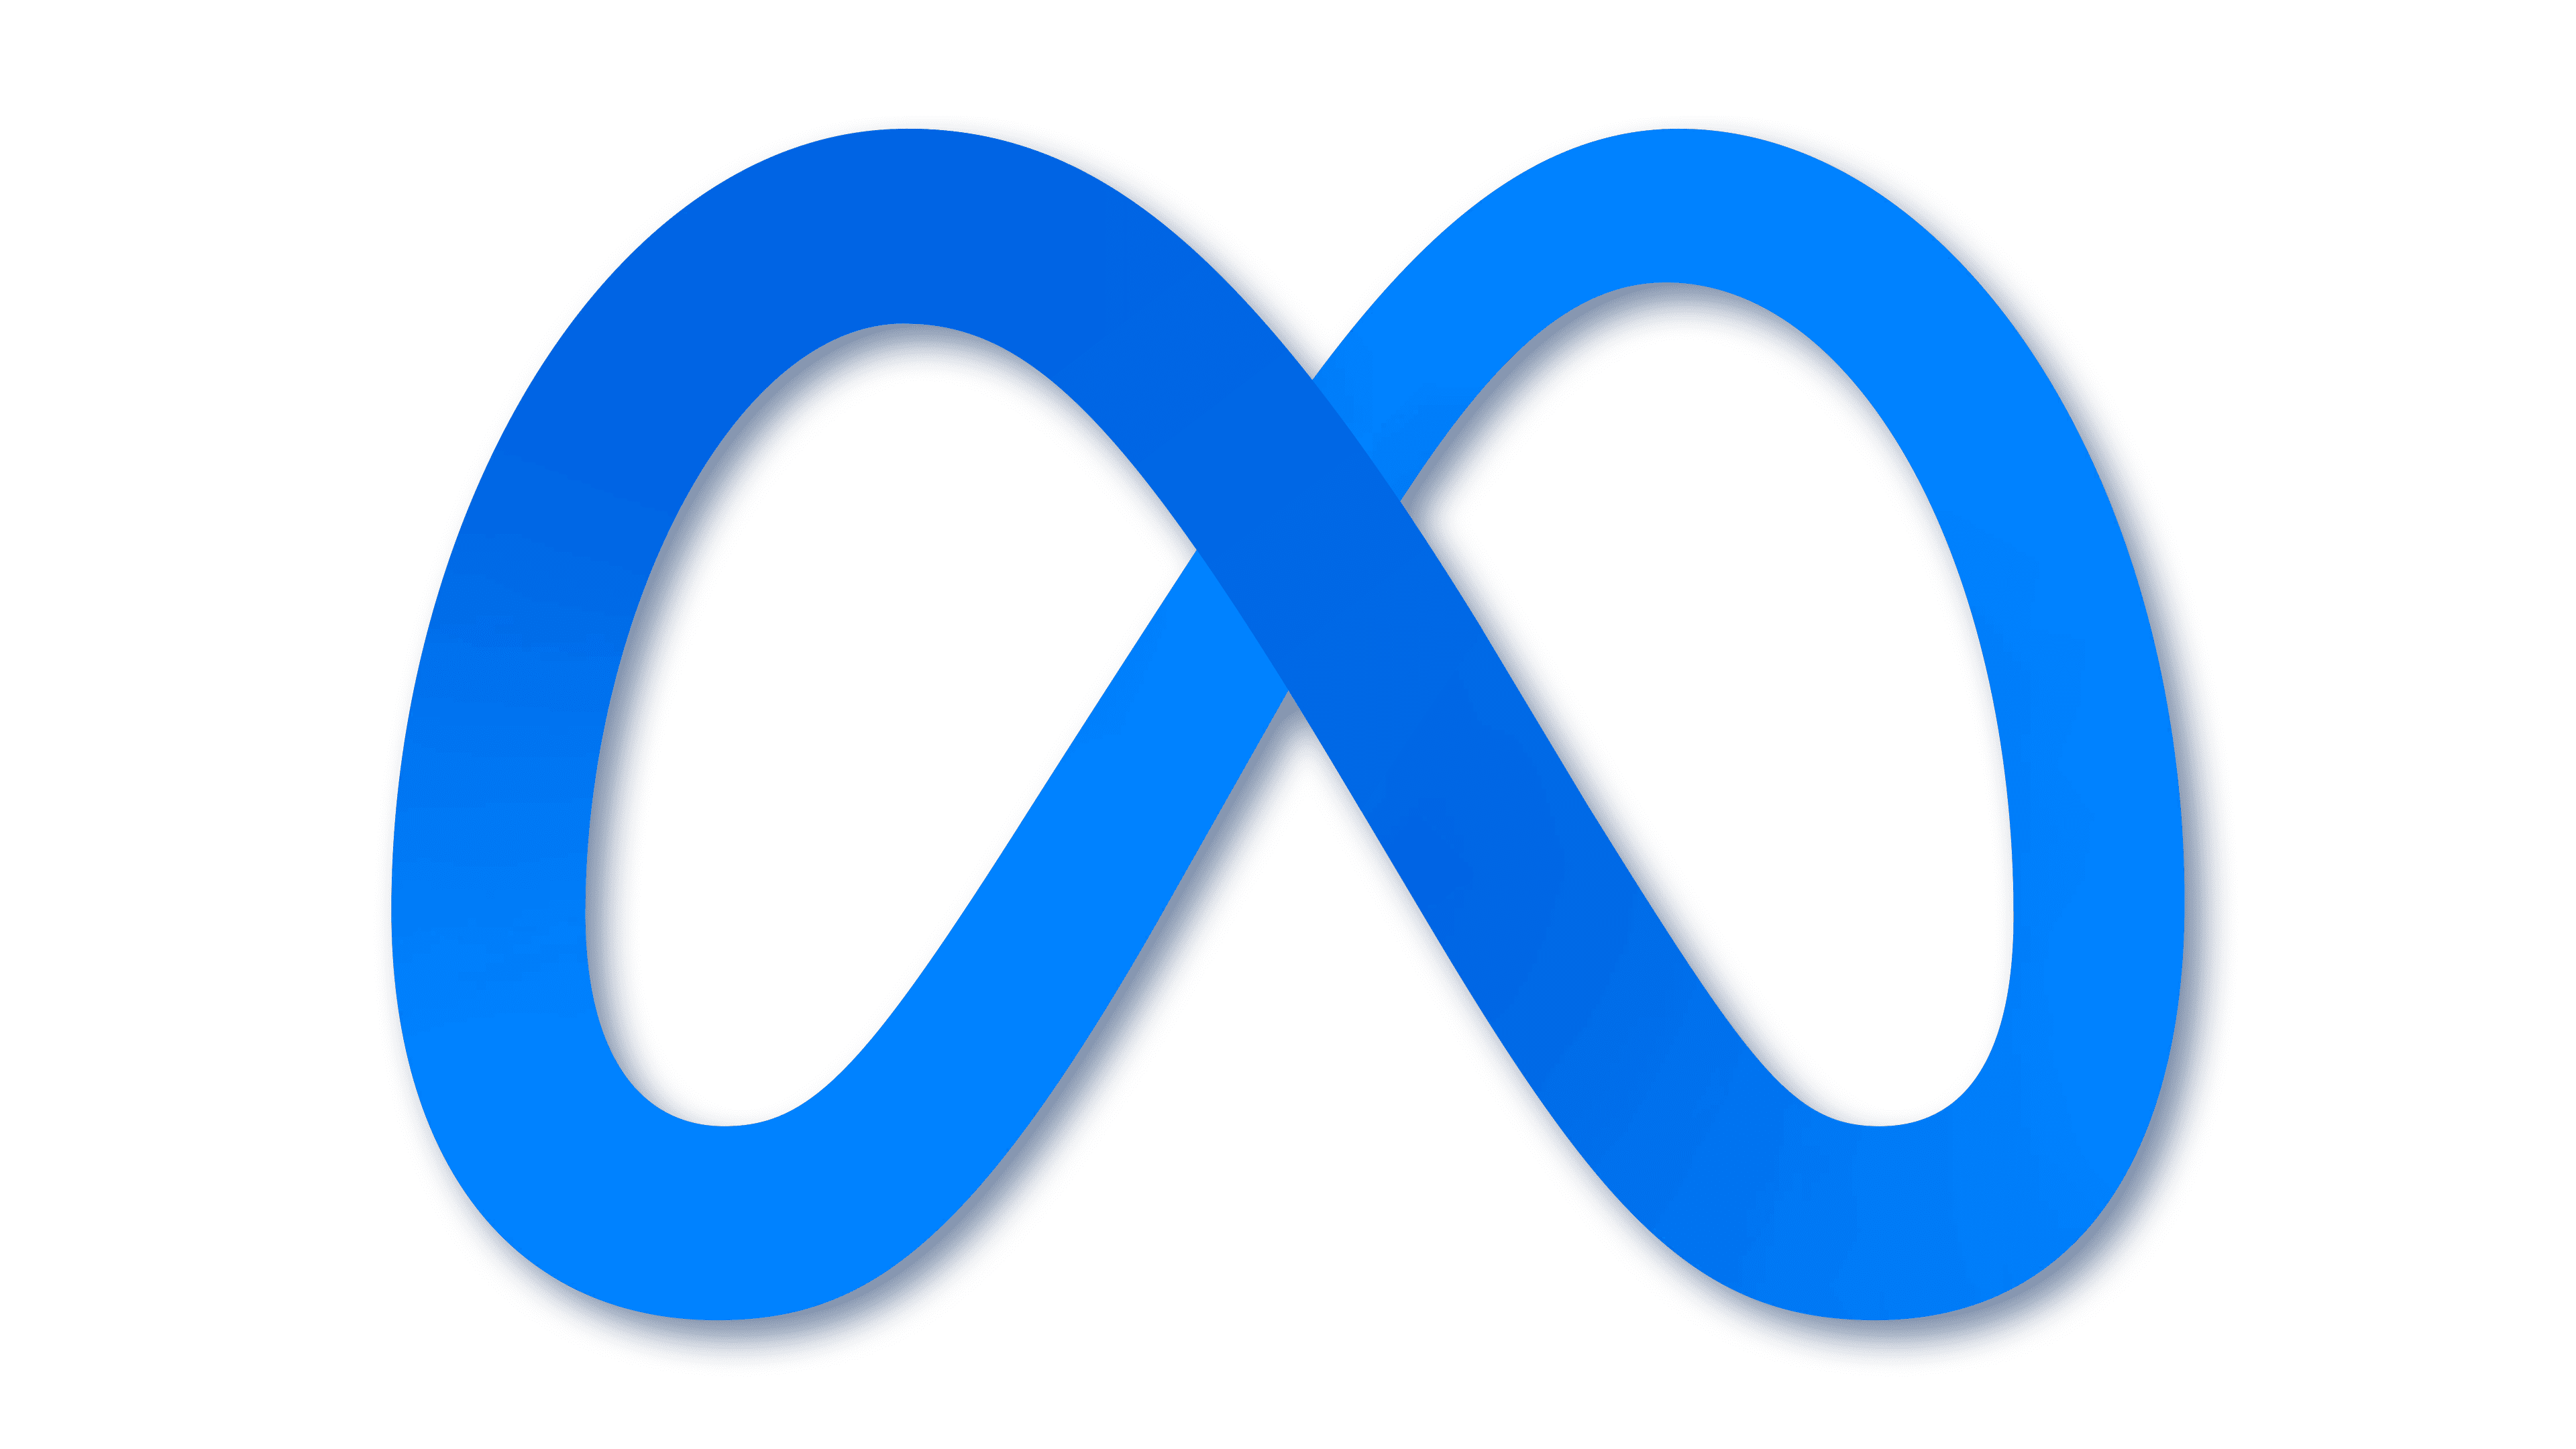
</div>


[**Nougat**](https://github.com/facebookresearch/nougat?tab=readme-ov-file) is an academic document PDF parser designed to extract and understand LaTeX math and tables from PDFs. Developed by **Facebook Research**, it converts academic documents into structured formats (Mathpix Markdown, *.MMD*).

Key Features:
- Extracts and processes LaTeX math, tables, and text.
- Converts PDFs to Mathpix Markdown (.mmd) format.
- Supports GPU for faster processing.

Nougat is optimized for scientific papers, especially those found on platforms like arXiv, and works best with English papers.

The approach for this project is to leverage Nougat as a *targeted solution* for extracting content from pages that present particular challenges, such as those containing mathematical fomulas, on which Unstructured performed poorly.

> *But why wasn't `Nougat` applied to the entire PDF?* The reason is that the selected PDF is over 300 pages long, and processing it with Nougat for the entire document would have been time-consuming. Instead, we used `Unstructured` to identify the pages containing formulas and applied `Nougat` only to those problematic pages. This resulted in a faster and more efficient overall workflow, while maintaining accuracy.

> As a side note, unfortunately Nougat requires `transformers==4.38.2` or below, which is uncompatible with `sentence-transformers`, since it requires `transformers<5.0.0,>=4.41.0`. A solution to this is to keep them separated in two different virutal environments. For the sake of semplicity, in the notebook we will simply upgrade `transformers` later on in order to utilize `sentence-transformers` without any problems.

In [74]:
# install some pre-requisites for Nougat
%pip install -qqq -U albumentations
%pip -qqq install transformers==4.38.2 --progress-bar off

# install Nougat
%pip -qqq install nougat-ocr  --progress-bar off

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
effdet 0.4.1 requires timm>=0.9.2, but you have timm 0.5.4 which is incompatible.


Now we can simply invoke Nougat, by calling the corresponding CLI command. More information about it can be found on its [README page](https://github.com/facebookresearch/nougat?tab=readme-ov-file). Here it is called by simply passing:
- the path of the PDF file in analysis
- `-o`, the output folder
- `--pages`, to specify only pages containing mathemathical formulas
- `-m 0.1.0-base`, to utilize the base model (default to `0.1.0-small` but didn't produce acceptable results)
- `--no-skipping`, to avoid using failure detection heuristic (this was added because, as from the Nougat readme, *'on some devices the failure detection heuristic are not working properly'*, and it is suggested to run it with this flag)

This step requires approximately from 2 to 5 minutes.

>  NOTE : If the file already exists, the command **WON'T** be re-executed. Call Nougat again and pass `--recompute` to ignore this

In [75]:
# Nougat is 1-indexed, so we need to increment the page indexes by 1
nougat_formulas_indexes = [index + 1 for index in pages_with_formulas_indexes]

nougat_formulas_indexes_str = ",".join(map(str, sorted(nougat_formulas_indexes)))
print(nougat_formulas_indexes_str)

command = f'nougat "{PDF_NAME}" -o ./nougat-output --pages {nougat_formulas_indexes_str} -m 0.1.0-base --no-skipping'

print(command)

!{command}

90,95,96,97,98,137,143,158,161,166,169,181,182,183,185,188,190,194,195,204,209,211
nougat "Information Retrieval Slides.pdf" -o ./nougat-output --pages 90,95,96,97,98,137,143,158,161,166,169,181,182,183,185,188,190,194,195,204,209,211 -m 0.1.0-base --no-skipping


C:\Users\giuli\miniconda3\envs\lm\Lib\site-packages\nougat\transforms.py:146: UserWarning: Argument 'alpha_affine' is not valid and will be ignored.
  alb.ElasticTransform(
C:\Users\giuli\miniconda3\envs\lm\Lib\site-packages\torch\functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3596.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
INFO:root:Skipping Information Retrieval Slides.pdf, already computed. Run with --recompute to convert again.


The output can be found in the `nougat-output` folder, as an MMD file. Since of course the model can fail to identify some sentences, we also perform some preprocessing of the text, to ensure it will be sanitized for the next phases.

In [76]:
def remove_unmatched_left_tags(line):
        if "\\left|" in line and "\\right|" not in line:
            line = line.replace("\\left|", "")
        return line

def preprocess_content(content):
    content = content.replace("**", "").replace("##", "")  # Some unuseful markdown is inserted sometimes
    content = content.replace("{(}", "(").replace("{)}", ")") # replace all '{(}' and '{)}' with '(' and ')'
    content = content.replace("{[}", "(").replace("{]}", ")") # replace all '{[}' and '{]}' with '(' and ')'
    content = re.sub(r'\$(.*?)\$', r'\\(\1\\)', content) # replace all '$' with '\(\)' (inline formulas)
    content = re.sub(r'\\text\{(.*?)\}', r'\1', content) # replace all '\text' with ''
    content = re.sub(r'_(.*?)_', r'\1', content) # replace words inside '_word_' with the same word -> e.g. _Proof:_ -> Proof:
    content = re.sub(r'\\includegraphics\[width=.*?pt\]', '', content) # replace all \includegraphics[width=....pt] with '', independently of the width
    content = "\n".join(remove_unmatched_left_tags(line) for line in content.splitlines()) # remove all \left|\ tags that don't have a \right|\ tag in the same line (they are not closed)        
    content = content.replace('\\\\', '\\') # substitute '\\' with '\', since it's not necessary to escape the backslash for later
    content = content.strip()
    return content


with open(f'nougat-output/{PDF_NAME.replace(".pdf",".mmd")}', 'r') as f:
    content = f.read()


processed_content = preprocess_content(content)


with open(f'nougat-output/{PDF_NAME.replace(".pdf",".mmd")}', 'w') as f:
    f.write(processed_content)


print(processed_content[:200], " ...\n\n..........................................")

Jaccard Coefficient

* A common measure of overlap of two (finite) sets \(A\) and \(B\): \[J(A,B)=\frac{|A\cap B\,|}{|A\cup B\,|}\]
* Always assigns a number between 0 and 1
* \(A\) and \(B\) do not h  ...

..........................................


# Creating the chunks

Before proceeding, we clean up the `df_elements` DataFrame by removing consecutive duplicate rows while retaining the first occurrence. This issue was present sometimes in our case because Unstructured sometimes duplicated Page Titles, or somtimes because the PDF contained white-on-white text, which resulted in duplicate content for the same page. Cleaning the DataFrame ensures to avoid redundancy.

In [77]:
# drop adjacent duplicates in the df_elements mantaining the first one
df_elements = df_elements.loc[df_elements.shift().ne(df_elements).any(axis=1)]

# reset index
df_elements = df_elements.reset_index(drop=True)

In [78]:
print("Final number of pages (given by the number of PageBreak(s)):",len(df_elements[df_elements['Type'] == PageBreak]))

Final number of pages (given by the number of PageBreak(s)): 300


Tokenization is the process of breaking a text into smaller units, such as words or phrases, which is a fundamental step in text preprocessing for natural language processing (NLP) tasks. We use the  **Natural Language Toolkit (NLTK)** for this task and counting tokens.

In [79]:
import nltk
from nltk.tokenize import word_tokenize

nltk.download('punkt_tab')

def count_tokens(text):
  return len(word_tokenize(text))

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\giuli\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Here we compute some statistics regarding the number of tokens in the pages.

In [80]:
# compute the max, the min and the average number of tokens in a page by concatenating elements of the dataframe between consecutive page breaks

num_token_per_page = []

current_page = ""
current_page_tokens = 0

for i in range(len(df_elements)):
  if df_elements.iloc[i]['Type'] != PageBreak:
    current_page += df_elements.iloc[i]['Value']
    current_page_tokens = count_tokens(current_page)
  else:
    num_token_per_page.append(current_page_tokens)
    current_page = ""
    current_page_tokens = 0

print("Max tokens: " + str(max(num_token_per_page)))
print("Min tokens: " + str(min(num_token_per_page)))
print("Avg tokens: " + str(sum(num_token_per_page)/len(num_token_per_page)))

Max tokens: 558
Min tokens: 1
Avg tokens: 68.28


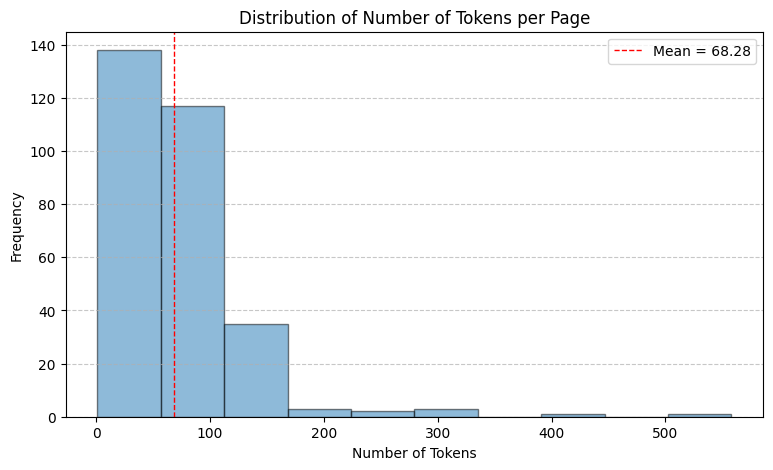

In [81]:
from matplotlib import pyplot as plt
import numpy as np

mean_tokens = np.mean(num_token_per_page)

plt.figure(figsize=(9, 5))
plt.hist(num_token_per_page, bins=10, edgecolor='black', alpha=0.5)
plt.axvline(mean_tokens, color='red', linestyle='dashed', linewidth=1, label=f'Mean = {mean_tokens:.2f}')
plt.title('Distribution of Number of Tokens per Page')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Splitting Content into Tokenized Chunks

We can now divide the processed elements in `df_elements` into smaller text files, ensuring that each file stays within a token limit.

The following code is designed to split the content into manageable chunks while maintaining logical consistency and handling page breaks effectively.

Two key parameters are defined for efficient chunking:
- **`doc_tokens_threshold`**: The maximum number of tokens allowed per chunk.
- **`overlap_tokens`**: The number of tokens to overlap between consecutive chunks, which helps maintain coherence between chunks.

These parameters are document-dependent, and experimenting with different values can help achieve better results depending on the structure and complexity of the document.

### **Processing and Chunking the Content:**
The main loop processes the `df_elements` dataframe, splitting the content based on the following rules:
- If the next element would cause the chunk to exceed the token limit, the current chunk is saved, and the next chunk starts with a portion of the previous one (based on the overlap).
- When encountering a `PageBreak`, the content is saved, and the next block starts on the new page, again with an overlap.

This process ensures that:
- The token limit is respected for each chunk.
- The context is preserved by maintaining overlap between chunks.
- The integrity of formulas and page transitions is respected.

In [82]:
def save_chunk(content, index):
    with open(f'chunks/document_{index}.mmd', 'w') as f:
        f.write(content)
    docs_len.append(count_tokens(content))
    return index + 1



# Create a directory to store the chunks
if not os.path.exists('chunks'):
    os.makedirs('chunks')
else:
    for file in os.listdir('chunks'):
        os.remove(os.path.join('chunks', file))

block = ""
document = ""
doc_index = 0
doc_tokens_threshold = 300
overlap_tokens = 30
docs_len = []

# Iterate over the elements of the dataframe
for i in range(len(df_elements)):
    element_type = df_elements.at[i, 'Type']
    next_element = df_elements.at[i, 'Value'] + " "

    if element_type != PageBreak:
        if count_tokens(block) + count_tokens(next_element) > doc_tokens_threshold:
            doc_index = save_chunk(block, doc_index)
            overlap = block.split()[-overlap_tokens:]
            block = " ".join(overlap) + " " + next_element
        else:
            block += next_element
    else:
        if block:  # if there is content in the block
            if document:  # if there is content in the document
                if count_tokens(document) + count_tokens(block) > doc_tokens_threshold:
                    doc_index = save_chunk(document, doc_index)
                    # maintain overal also for pages
                    overlap = document.split()[-overlap_tokens:]
                    document = " ".join(overlap) + " " + block
                else:
                    document += block
            else:
                document = block
            block = ""

# handling last block
if block:
    if document:
        if count_tokens(document) + count_tokens(block) > doc_tokens_threshold:
            doc_index = save_chunk(document, doc_index)
            doc_index = save_chunk(block, doc_index)
        else:
            doc_index = save_chunk(document + block, doc_index)
    else:
        doc_index = save_chunk(block, doc_index)
elif document:
    doc_index = save_chunk(document, doc_index)

print("Number of chunks obtained: " + str(doc_index))

Number of chunks obtained: 103


Up to now, we have not used the output resulted by **Nougat**: for the `Information Retrieval Slides.mmd` file produced, we apply a custom approach.

We use the **`CharacterTextSplitter`** from LangChain to split the text into chunks, as the content is continuous and requires a different processing strategy compared to documents with page breaks.

Again, `chunk_size` and `chunk_overlap` are document specific values, and changing them may produce better results depending on the type of document to analyze.

In [83]:
from langchain_text_splitters import CharacterTextSplitter


text_splitter = CharacterTextSplitter.from_tiktoken_encoder(
    encoding_name="cl100k_base", chunk_size=500, chunk_overlap=50
)
texts = text_splitter.split_text(processed_content)

for t in texts:
    doc_index = save_chunk(t, doc_index)

print("Number of chunks obtained: " + str(doc_index))

Number of chunks obtained: 117


In [84]:
# print the max, the min and the avg of values in docs_len
print("Number of documents: ",len(docs_len))
print("Maximum number of tokens in a document: ",max(docs_len))
print("Minimum number of tokens in a document: ",min(docs_len))
print("Average number of tokens in a document: ",sum(docs_len)/len(docs_len))

Number of documents:  117
Maximum number of tokens in a document:  546
Minimum number of tokens in a document:  137
Average number of tokens in a document:  268.8888888888889


# RAG Pipeline on PDFs with Limited GPU Requirements

Now, our aim is to build a **Retrieval-Augmented Generation (RAG)** pipeline optimized for a **limited GPU environments**. The goal is to combine the power of *dense retrieval-based methods* with the flexibility of generative models, while ensuring the system remains efficient enough to run on medium-tier laptops with GPUs.

As said in the introduction, a RAG pipeline consists of two main stages: **retrieval** and **generation**. The entire process can be divided into **3 key steps**:

1. **Generation of document embeddings**  
   In this step, document embeddings are generated from a *corpus* using an embedding model. Each document is encoded into a dense vector representation, capturing semantic information.

2. **Document retrieval**  
   Relevant documents are fetched from the corpus based on the input query. This is achieved by utilizing the generated embeddings and calculating similarity with the query's embedding to retrieve the most relevant documents.

3. **Output generation**  
   The retrieved documents are then passed to a **generative model**, which produces contextually relevant responses based on the information extracted from the documents.

By leveraging lightweight models and optimizing for efficiency, this RAG pipeline should be able to deliver good results even on hardware with **limited resources**.

Finally, a **Gradio interface** is provided, allowing users to interact with the system and ask question related to the documents they provide.

## Hardware requirements and constraints

Let's find out what hardware we've got available to see what kind of model(s) we'll be able to load. You can also check this with the `!nvidia-smi` command.

> **NOTE** : as said above, `sentence-transformers` requires a different version of the `transformers` library, so we update it here.

In [85]:
%pip install -qqq -U transformers

Note: you may need to restart the kernel to use updated packages.


In [86]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [87]:
# Get GPU available memory
gpu_memory_bytes = torch.cuda.get_device_properties(0).total_memory
gpu_memory_gb = round(gpu_memory_bytes / (2**30))
print(f"Available GPU memory: {gpu_memory_gb} GB")
print(torch.cuda.get_device_name(0))

Available GPU memory: 8 GB
NVIDIA GeForce RTX 3070 Laptop GPU


Of course, depending on the provided harware, better models can be utilized.

### Checking local GPU memory availability

Let's first analyze how we decided the model to use for this project. This notebook was primarily run and tested locally on a **laptop** with 16GB of RAM and an NVIDIA RTX 3070 laptop GPU (8GB of VRAM). The main goal was to create a pipeline that could efficiently run on this portable device, leveraging the benefits of GPUs and CUDA for AI tasks while ensuring that the performance and capabilities did not feel lacking compared to larger models.

We will need two main ingredients:
- An *embedder* model, that calculates dense embeddings from documents
- An *LLM*, that provides output given user's queries and the retrieved documents

In their dedicated sections we will uncover the choices made for both.

First, we will need an HuggingFace token, in order to utilize the proposed large language model. 

In [88]:
from huggingface_hub import login
from dotenv import load_dotenv

running_on_colab = False

try:
    from google.colab import userdata # type: ignore
    HF_TOKEN = userdata.get('HF_TOKEN')
    print("Running in Google Colab. Using userdata to get HF_TOKEN.")
    running_on_colab = True
except ModuleNotFoundError:
    load_dotenv()
    HF_TOKEN = os.getenv('HF_TOKEN')
    print("Not running in Google Colab. Using load_dotenv to get HF_TOKEN.")

login(token=HF_TOKEN)

Not running in Google Colab. Using load_dotenv to get HF_TOKEN.


Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


We can now simply load the produced chunks in the previous phase. They will be stored in the `corpus` array.

In [89]:
corpus = []

# get files that are named 'document_<number>.mmd'
files = sorted([f for f in os.listdir("chunks") if f.startswith("document_") and f.endswith(".mmd")],
    key=lambda x: int(x.split("_")[1].split(".")[0])  # order numerically by the number in the filename
)

for file in files:
    with open(os.path.join("chunks", file), "r", encoding="utf-8") as f:
        corpus.append(f.read())

print(f"Number of documents loaded: {len(corpus)}")

Number of documents loaded: 117


Let's give a look to some random documents extracted and preprocessed from the initial pdf

In [90]:
import random

random.seed(4242)

# print some random pages with their indices
for i in range(5):
    doc = random.choice(corpus)
    doc_index = corpus.index(doc)
    text = doc.replace('\n', ' ')
    print(f"DocId: {doc_index}, {text[:100]}...")

DocId: 110, This contradicts the assumption that \(E[R{\bar{k}}(d{l})]\) was maximal.  PRP Assumptions  * We ass...
DocId: 53, space S = {1,2,3,4,5,6} Event "the outcome is odd": Eodd = {1,3,5} Event "the outcome is even": Eeve...
DocId: 16, he wept When at Philippi he found Brutus slain. Hamlet, Act III, Scene ii Lord Polonius: I did enact...
DocId: 3, 0xBF UTF-8 sequences must be of the following forms in binary, where the x's represent the bits from...
DocId: 78, expanded query, the terms are not re-weighted We can't differentiate the informative terms from the ...


Later, we will use a `json` file containing questions to test the pipeline: it is made up by 60 open-questions we prepared on the PDF topic, in order to asses the final RAG capabilities. For now, we’ll download this file and use it also in this phase to ensure the pipeline works as expected.


The file,  `open_questions.json` contains open-answer questions, where an entry looks like:

```json
    {
        "question_id": "1",
        "question": "What is Jaccard Coefficient?"
    }, ...
```
<div align="center">

| **Field**       | **Content**                                     |
|------------------|-------------------------------------------------|
| `question_id`    | Unique identifier of the question        |
| `question`       | The question text                              |

</div>

---

We’ll begin by defining the function `extract_questions(file_path)`, which takes as parameter:

- `file_path`: the path to the JSON file containing the questions, expected as in the above format.


In [91]:
import json


def extract_questions(file_path):
    """
    Extracts questions from a JSON file.
    """
    with open(file_path, 'r') as file:
        data = json.load(file)
        return [
            {
                "question_id": item.get("question_id", ""),
                "question": item.get("question", "")
            }
            for item in data
        ]


if not os.path.exists("evaluation"):
    os.makedirs("evaluation")
    # save locally from https://drive.google.com/file/d/1L6rvrbPtwGduaN-8DmpLAWXUtHSfhhF2/view?usp=sharing
    gdown.download(id="1L6rvrbPtwGduaN-8DmpLAWXUtHSfhhF2", output="evaluation/open_questions.json", quiet=False)

queries = extract_questions("evaluation/open_questions.json")
print(f"Loaded {len(queries)} questions.")

random.seed(4242)
print(random.choice(queries))

Loaded 60 questions.
{'question_id': '56', 'question': 'What is Average Precision AP?'}


## Gather Dataset Embeddings

In this first stage, the aim is to produce the documents embeddings, in order to be able to make similarity searches in the upcoming steps of the pipeline.

### About the `cde-small-v1` Model

The `cde-small-v1` model, developed by John X. Morris and Alexander M. Rush, is a state-of-the-art model for generating **Contextual Document Embeddings (CDE)** ([HuggingFace link](https://huggingface.co/jxm/cde-small-v1)). What sets this model apart is its ability to integrate "*context tokens*" into the embedding process, which allows it to capture the relationships between documents more effectively. This makes it particularly suitable for generating highly accurate embeddings for both documents and queries, especially in cases where capturing the context of a document within the broader corpus is crucial.

We chose this model because, as of January 2025, it is one of the leading models under 400M parameters, delivering impressive results on the [**Massive Text Embedding Benchmark (MTEB) leaderboard**](https://huggingface.co/spaces/mteb/leaderboard). Although it ranks 29th overall, it stands out as the top model in terms of **memory efficiency**, which is a key factor for our project, given the requirement for **limited GPU capabilities**. Additionally, it offers an **embedding dimension of 768**, that should strike a balance between computational efficiency and embedding quality.

<div align="center">
    <img src="https://huggingface.co/front/assets/huggingface_logo-noborder.svg" alt="HF logo">
</div>


<style>
    img {
        border-radius: 15px;
    }
</style>
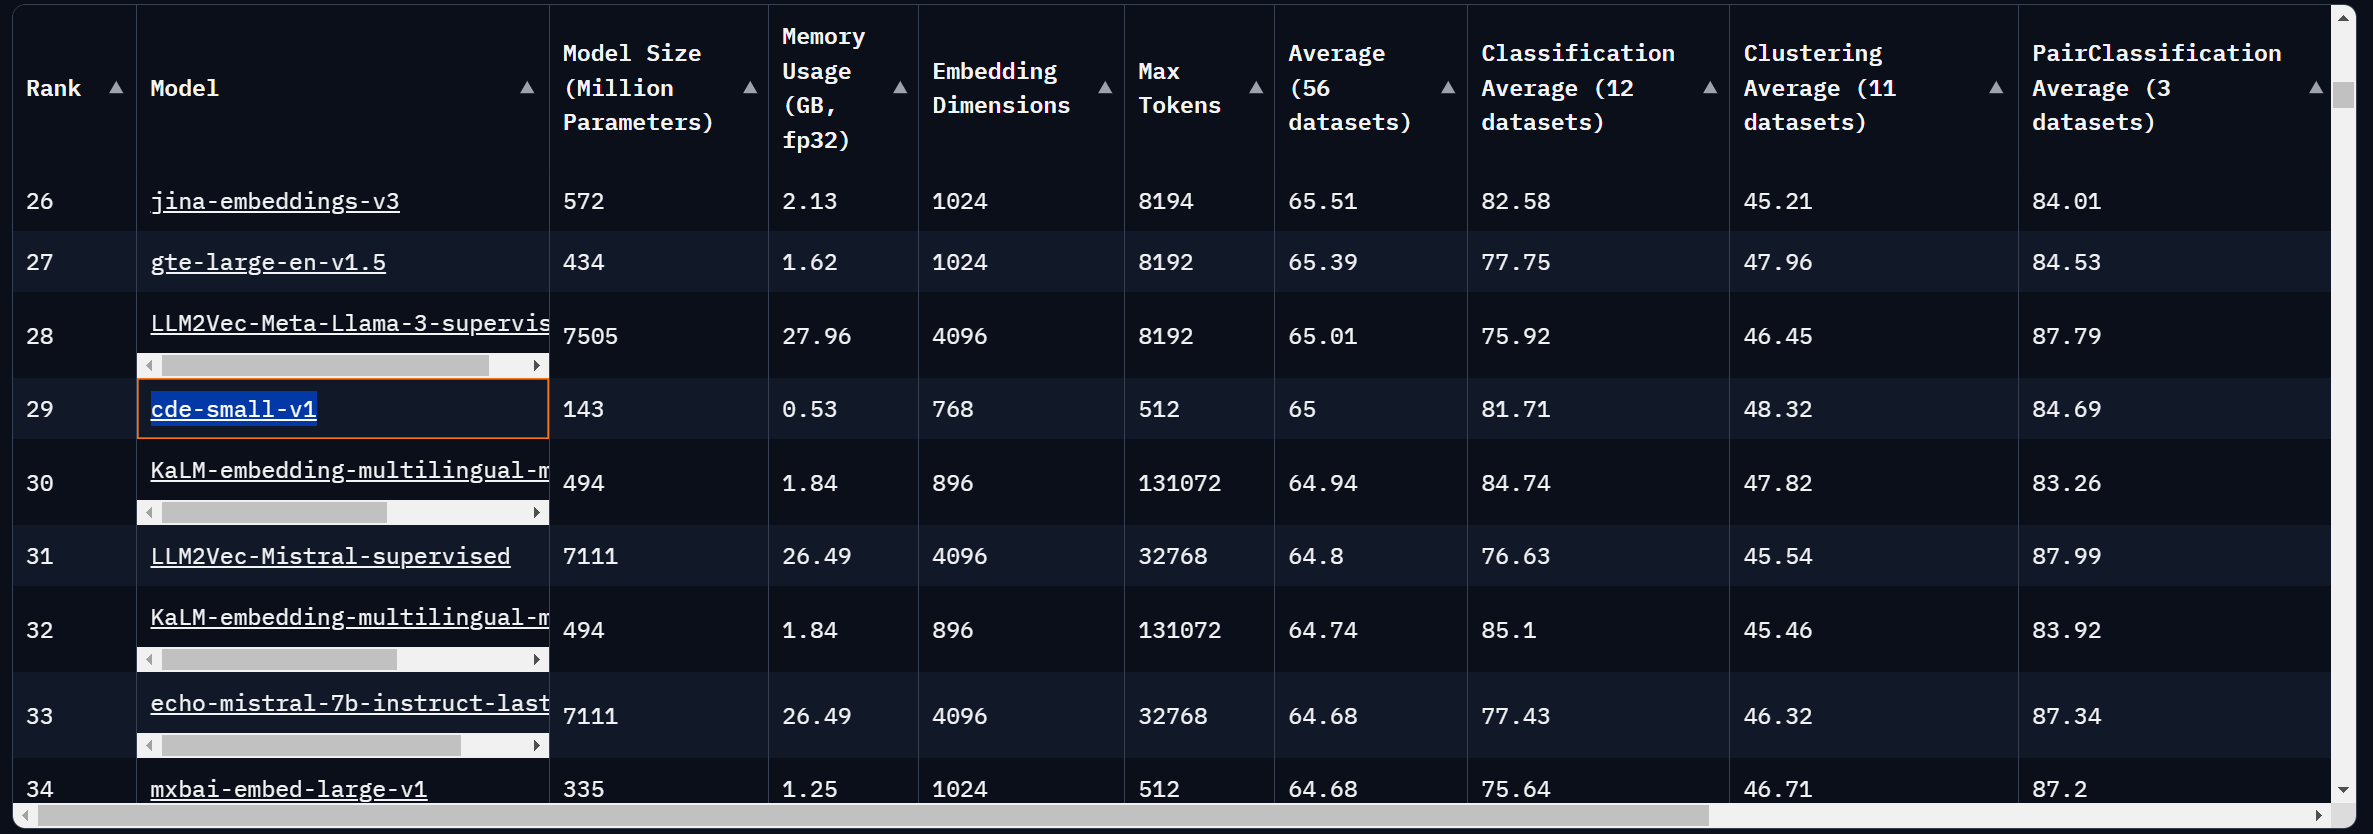

### Key Features of Contextual Embeddings
Traditional embedding models treat documents as independent entities, which can miss subtle but important relationships within a corpus. The `cde-small-v1` model solves this by incorporating **contextual embeddings**, where a document's representation is enriched with information from related documents.

This is achieved by:

- **Contextual Batching**: Documents are grouped into clusters based on their similarity. For a document , its context is derived from nearby documents in the embedding space.
- **Integrating Context**: The model combines the target document's standalone embedding with the aggregated representation of its cluster to produce a final, enriched embedding.
This process ensures that embeddings are not only descriptive of individual documents but also reflective of their relationships within the corpus.

In particular , to train the `cde-small-v1` model, *contrastive learning* is used. This method ensures that similar documents are placed closer in the embedding space while dissimilar documents are pushed farther apart.

Basically, documents from the same cluster or context are treated as similar pairs and dissimilar documents (*hard negatives*) are included to make the training process more effective and robust

During training, the model optimizes a loss function that aims to balances these relationships:
- *Positive Pair*: Maximizes similarity between a query and a relevant document.
- *Negative Pair*: Minimizes similarity between a query and irrelevant documents.

This approach should leads to embeddings that are capable of accurately distinguishing between relevant and irrelevant documents, even in complex domains.

<style>
    img {
        border-radius: 15px;
    }
    .center {
        display: flex;
        justify-content: center;
    }
    .center img {
        width: 50%;
    }
</style>
<div class="center">
    <img src="https://i.imgur.com/LyXJZjM.png" alt="cde-small-v1">
</div>


### Usage

A key feature of the `cde-small-v1` model is its optimization for a three-stage embedding process:

1. **First Stage**: Embedding a subset of documents from the corpus to create "dataset embeddings," which serve as a **reference (context)** for the entire corpus
2. **Second Stage**: Utilize the "dataset embeddings" to produce **Contextual Embeddings** for all the documents.
3. **Third Stage**: Utilize the "dataset embeddings" also to embed new queries during inference, and to obtain results based on similarity.

This model is compact yet delivers solid performance, making it suitable for our use case.


Next, we will load the model using the `SentenceTransformers` interface to begin the embedding process.

In [92]:
from sentence_transformers import SentenceTransformer

embeddings_model = SentenceTransformer(
    "jxm/cde-small-v1",
    trust_remote_code=True,
).to(device)

C:\Users\giuli\.cache\huggingface\modules\transformers_modules\nomic-ai\nomic-bert-2048\40b98394640e630d5276807046089b233113aa87\modeling_hf_nomic_bert.py:108: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related

Disabled 37 dropout modules from model type <class 'transformers_modules.jxm.cde-small-v1.9e2ed1d8d569d34458913d2d246935c1b2324d11.model.BiEncoder'>
modified 12 rotary modules – set rotary_start_pos to 512
Disabled 74 dropout modules from model type <class 'transformers_modules.jxm.cde-small-v1.9e2ed1d8d569d34458913d2d246935c1b2324d11.model.DatasetTransformer'>


During the development of the project, the creators of the embedding model made a change in the Hugging Face repository, which led to unstable results when using the `SentenceTransformer` implementation. If a similar issue arises in the future, it can be mitigated by specifying the `revision` and `tokenizer_kwargs` parameters in the model constructor. These parameters allow to lock the model and tokenizer to a specific branch name, tag, or commit ID from the Hugging Face repository, ensuring stability.

Here’s how to implement it:

```python
embeddings_model = SentenceTransformer(
    "jxm/cde-small-v1",
    trust_remote_code=True,
    revision="9e2ed1d8d569d34458913d2d246935c1b2324d11",  # Latest stable model revision
    tokenizer_kwargs={"revision": "86b5e0934494bd15c9632b12f734a8a67f723594"}  # Latest stable tokenizer revision
).to(device)
```

The tags provided above correspond to the latest stable commits (as of December 2024). You can retrieve them directly from the model's card page on Hugging Face, under the "Files and Versions" tab.

Fortunately for us, the issue was resolved the same day we reported it to the creators via Twitter. We thank them for their prompt response and the fix they provided.

### Steps to Gather Dataset Embeddings:

1. **Selecting a Subset of Documents**  
We begin by sampling a representative set of documents from the corpus. Following the model's guidelines, we select 512 documents. If this number isn't available, the model can handle oversampling, which is the case for the PDF dataset we're using. Despite this, performance remains strong. 

The next cell produces the `minicorpus` (which is the subsample of the whole corpus) and what we called `dataset_embeddings`

In [93]:
minicorpus_size = embeddings_model[0].config.transductive_corpus_size # 512
random.seed(4242)
minicorpus_docs = random.choices(corpus, k=minicorpus_size) # oversampling is okay
assert len(minicorpus_docs) == minicorpus_size # We must use exactly this many documents in the minicorpus

dataset_embeddings = embeddings_model.encode(
    [doc for doc in minicorpus_docs],
    prompt_name="document",
    convert_to_tensor=True,
    show_progress_bar=True
)

print(f"Corpus size: {len(corpus)}")
print(f"Computed embeddings for {len(minicorpus_docs)} documents. Shape: {dataset_embeddings.shape}")

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

Corpus size: 117
Computed embeddings for 512 documents. Shape: torch.Size([512, 768])


In [94]:
print("Some mini-corpus documents:")

# get some random documents from the minicorpus
random.seed(4242)
for i in random.sample(range(minicorpus_size), 5):
    text = minicorpus_docs[i].replace('\n', ' ')
    print(f"document {i}: {text[:100]}...")

Some mini-corpus documents:
document 425: ni R = number of relevant documents in the sample ri = number of relevant documents in the sample co...
document 134: This contradicts the assumption that \(E[R{\bar{k}}(d{l})]\) was maximal.  PRP Assumptions  * We ass...
document 29: inverse collection frequency factor (N is total f log; and n is number of documents number of docume...
document 399: term co- occurrence analysis Previous query reformulations of users (query logs) Thesauri & dictiona...
document 388: Compute query-document features Compute query-only features Compute query-only features Extract quer...


2. **Embed Documents**  
Now that we have obtained the **dataset embeddings**, we can proceed to embed both documents and queries using the same model. 

To embed the documents and queries, we must ensure that we specify the correct `prompt_name` for each, as well as pass the `dataset_embeddings` to maintain context. The reason is that, as many state-of-the-art-models, this one was trained with task-specific prefixes:

- For documents, use:  
  `prompt_name="document"`

- For queries, use:  
  `prompt_name="query"`

We also have to always additionally specify  the `dataset_embeddings`, in order to use the ones we produced before.

In [95]:
doc_embeddings = embeddings_model.encode(
    [doc for doc in corpus],
    prompt_name="document",
    dataset_embeddings=dataset_embeddings, # this is the contexualized embeddings of the minicorpus
    convert_to_tensor=True,
    show_progress_bar=True
)

queries_embeddings = embeddings_model.encode(
    [query['question'] for query in queries],
    prompt_name="query",
    dataset_embeddings=dataset_embeddings,  # this is the contexualized embeddings of the minicorpus
    convert_to_tensor=True,
    show_progress_bar=True
)

print(f"Document embeddings shape: {doc_embeddings.shape}")
print(f"Query embeddings shape: {queries_embeddings.shape}")

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Document embeddings shape: torch.Size([117, 768])
Query embeddings shape: torch.Size([60, 768])


We can now computes similarities between the embeddings and all the queries by simply calling `embeddings_model.similarity` (which uses by default **cosine similarity**), and inspect some of the results obtained.

In [96]:
similarities = embeddings_model.similarity(queries_embeddings, doc_embeddings)
print("similarities shape: ",similarities.shape)
topk_values, topk_indices = similarities.topk(5)

print("topk_values (scores) shape: ",topk_values.shape, "\ntopk_indices (doc_ids) shape: ",topk_indices.shape,"\n") # both are made up of tensors of shape (num_queries, k)

random.seed(4242)
random_queries = random.sample(queries, 2)
for query in random_queries:
    query_idx = queries.index(query)
    print(f"Query: {query['question']}")
    for j, idx in enumerate(topk_indices[query_idx]):
        doc = corpus[idx].replace("\n", " ")
        print(f"Rank {j+1} (Score: {topk_values[query_idx][j]:.4f}, Doc ID: {idx}): {doc}...")
    print()

similarities shape:  torch.Size([60, 117])
topk_values (scores) shape:  torch.Size([60, 5]) 
topk_indices (doc_ids) shape:  torch.Size([60, 5]) 

Query: What is Average Precision AP?
Rank 1 (Score: 0.6939, Doc ID: 47): standard Recall value we use the maximum Precision obtained for any actual Recall value greater than or equal to R iP@Rj = max P@R Rj Rj RRj Recall , : Average Precision Consider the rank position of each relevant document K1, K2, , KRB Compute P@k for each value k K1, K2, , KRB   The Average Precision AP is arithmetic mean of these P@k values The Mean Average Precision (MAP) is the mean of AP over a set of topics   Differently from the other measures, this mean has its own name since it is the most widely used single number to summarise the whole performance of a system Chris Buckley (US) Ellen M. Voorhees (US) Buckley, C. and Voorhees, E. M. (2005). Retrieval System Evaluation. In Harman, D. K. and Voorhees, E. M., editors, TREC. Experiment and Evaluation in Informatio

### Compute scores between queries and documents

Now we can analyze a similarity heatmap between the embeddings of our documents and the provided queries. The results show consistency with the following observations:

- **Few documents match the queries**: This suggests that the model likely works, as few documents are relevants to each question.
- **Matches often occur in subsequent documents**: This is expected since the corpus was split into chunks based on the document's structure. For example, chapters are separated, so answers to specific questions are more likely to be located within the same chapter or adjacent sections of the document.

Additionally, we provide a distribution of the similarity scores. This helps us assess whether an empirical threshold can be established to determine which documents are truly similar to the provided queries.

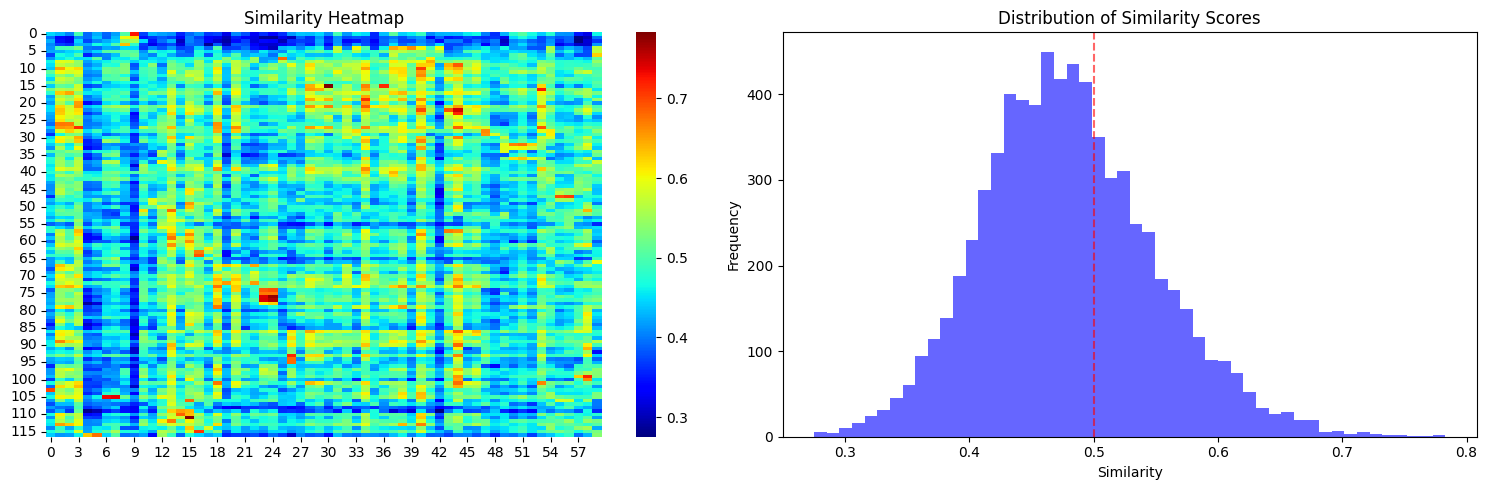

In [97]:
from seaborn import heatmap

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot heatmap
heatmap(similarities.cpu().numpy().T, cmap="jet", ax=axes[0])
axes[0].set_title("Similarity Heatmap")

# Plot histogram
axes[1].hist(similarities.cpu().flatten(), bins=50, color='blue', alpha=0.6)
axes[1].set_title("Distribution of Similarity Scores")
axes[1].set_xlabel("Similarity")
axes[1].set_ylabel("Frequency")
axes[1].axvline(x=0.5, color='red', alpha=0.6, linestyle='--')

plt.tight_layout()
plt.show()

## Embedding Evaluation

Before proceeding further, we evaluate the embedding model's performance. To facilitate this, we manually created a `qrels.tsv` file tailored to 60 open questions. This allows us to leverage standard information retrieval metrics for a comprehensive evaluation. 

The evaluation is conducted using the `ir_measures` library, which calculates various metrics commonly used in information retrieval. For this analysis, we set \( K=5 \) as the number of top results to return. This choice aligns with our downstream use case, where the LLM will later get five documents as context to generate responses.

In [98]:
# if not available inside ./evaluation, download the QRELS file
import os, gdown
if not os.path.exists("evaluation/qrels.tsv"):
    # save locally from https://drive.google.com/file/d/1K_qoYxLJ_hyoygsDG5EmrcnY9-QEdRyH/view?usp=sharing
    gdown.download(id="1K_qoYxLJ_hyoygsDG5EmrcnY9-QEdRyH", output="evaluation/qrels.tsv", quiet=False)
    print("QRELS file downloaded.")
else:
    print("QRELS file already exists.")

QRELS file already exists.


In [99]:
from ir_measures import *
from collections import defaultdict
import numpy as np
from rank_bm25 import BM25Okapi


def load_qrels(qrels_path):
    """
    Load qrels from a TSV (tab separated) file.
    Expected format: 
    query_id document_id relevance iteration
    """
    qrels = defaultdict(dict)
    with open(qrels_path, 'r') as file:
        for line in file:
            query_id, doc_id, relevance, _ = line.strip().split()
            qrels[query_id][doc_id] = int(relevance)
    return dict(qrels)


def evaluate_bm25_retrieval(queries, qrels, k=10, corpus=None):
    if corpus is None:
        raise ValueError("Corpus is not defined.")
    
    # Tokenize documents for BM25
    tokenized_docs = [doc.lower().split() for doc in corpus] # simply lowercase and split by whitespace
    bm25 = BM25Okapi(tokenized_docs)
    run = defaultdict(dict)
    
    for query in tqdm(queries, desc="Evaluating BM25 queries"):
        query_id = query['question_id']
        doc_scores = bm25.get_scores(query['question'].lower().split())
        
        # Get top k scores and their indices
        top_k_indices = np.argsort(doc_scores)[-k:][::-1] # [-k:] to get the last k elements, [::-1] to reverse the order
        
        # Store scores using document index as doc_id
        for idx in top_k_indices:
            run[query_id][str(idx)] = doc_scores[idx]

    # Save results to file
    with open("bm25_run.tsv", "w") as f:
        for query_id, doc_scores in run.items():
            for doc_id, score in doc_scores.items():
                f.write(f"{query_id}\t{doc_id}\t{score}\n")
    
    return calculate_metrics(qrels, run)


def evaluate_embedding_retrieval(queries, qrels, k=10):
        
    run = defaultdict(dict)

    for query in tqdm(queries, desc="Evaluating embedding queries"):
        query_id = query['question_id']
        
        query_embedding = embeddings_model.encode(
            query['question'],
            prompt_name="query",
            dataset_embeddings=dataset_embeddings,
            convert_to_tensor=True
        )
         
        similarities = embeddings_model.similarity(query_embedding, doc_embeddings)
        topk_values, topk_indices = similarities.topk(k)
        topk_indices = topk_indices.cpu().numpy()[0]
        topk_values = topk_values.cpu().numpy()[0]
        
        for doc_idx, score in zip(topk_indices, topk_values):
            run[query_id][str(doc_idx)] = float(score)
    
    with open("embedding_run.tsv", "w") as f:
        for query_id, doc_scores in run.items():
            for doc_id, score in doc_scores.items():
                f.write(f"{query_id}\t{doc_id}\t{score}\n")
                
    return calculate_metrics(qrels, run)


def calculate_metrics(qrels, run):
    metrics = [AP, nDCG, nDCG@5,  Precision@5, Recall@5, RR]
    return {str(metric): calc_aggregate([metric], qrels, run) for metric in metrics}


def compare_retrievals(queries, qrels, k=10, corpus=None):
    print("Running embedding-based retrieval...")
    embedding_metrics = evaluate_embedding_retrieval(queries, qrels, k)
    
    print("\nRunning BM25 retrieval...")
    bm25_metrics = evaluate_bm25_retrieval(queries, qrels, k, corpus)
    
    print("\nComparison Results:")
    print(f"{'Metric':25} {'Embedding':12} {'BM25':12}")
    print("-" * 44)
    
    for metric, emb_score in embedding_metrics.items():
        bm25_score = bm25_metrics[metric]
        if isinstance(emb_score, dict):
            for k, v in emb_score.items():
                metric_name = f"{metric}"
                print(f"{metric_name:25} {v:.3f}       {bm25_score[k]:.3f}")
        else:
            print(f"{str(metric):25} {emb_score:.3f}       {bm25_score:.3f}")


# Usage
qrels = load_qrels("evaluation/qrels.tsv")
print(f"Loaded {len(qrels)} QRELS and {len(queries)} questions.\n")
compare_retrievals(queries, qrels, k=5, corpus=corpus)

Loaded 60 QRELS and 60 questions.

Running embedding-based retrieval...


Evaluating embedding queries: 100%|██████████| 60/60 [00:07<00:00,  7.88it/s]



Running BM25 retrieval...


Evaluating BM25 queries: 100%|██████████| 60/60 [00:00<00:00, 6096.82it/s]


Comparison Results:
Metric                    Embedding    BM25        
--------------------------------------------
AP                        0.419       0.404
nDCG                      0.507       0.482
nDCG@5                    0.513       0.487
P@5                       0.270       0.270
R@5                       0.503       0.511
RR                        0.672       0.589


### **Comparison Analysis**

**Overall Performances:**
Even if the margin of improvement is modest, the *embedding-based approach* outperforms BM25 in most metrics, indicating a stronger semantic understanding of the queries and documents. This also suggests that BM25 remains a strong baseline for this task.

**Precision and Ranking Quality**:
   - **Average Precision (AP)**: Embeddings lead slightly, indicating a better overall ranking quality across the results.
   - **nDCG and nDCG@5**: Embeddings outperform BM25, highlighting their ability to prioritize relevant documents, especially at the top of the ranking.
   - **Precision@5**:  Identical values suggest that both models are equally precise when restricted to the top-5 results. This metric implies that neither method achieves a clear advantage in pure top-k precision.
   - **Recall@5**: BM25 performs marginally better, suggesting it retrieves slightly more relevant documents in the top-5 results.
   - **Reciprocal Rank (RR)**: The embedding model shows a *significant advantage*, emphasizing its strength in finding the first relevant document efficiently.


#### **Practical Implications**
- **Use Cases**:
   - **Embedding Model**:
     - Best suited for scenarios where finding the most relevant document quickly is critical, such as question answering.
     - The ranking metrics indicate that it can handle more complex semantic queries effectively.
   - **BM25**:
     - May be preferable in tasks emphasizing broader coverage (e.g., exploratory search) due to slightly higher recall.

- **Efficiency**:
   - Embedding-based retrieval can be more computationally expensive due to the need for embedding generation and similarity computations. 
   - BM25 is lightweight and faster, making it suitable for scenarios with limited computational resources or real-time requirements.

#### **Conclusion**

The results demonstrate that embedding-based methods provide stronger semantic retrieval capabilities, while BM25 offers competitive baseline performance with slightly better coverage. Results, however, are influenced by the specific PDF and queries used. With a more *discursive* PDF and more context-driven queries, we expect the embedding model to outperform BM25 more significantly.

## Loading the LLM

After conducting some research, we chose to work with one of Meta's latest smaller open-source Llama models available at the time of writing this notebook: [Llama-3.2-3B-Instruct](https://huggingface.co/meta-llama/Llama-3.2-3B-Instruct), released the *25th of September 2024*. We specifically selected the *instruct* variant because it is pre-trained to follow basic instructions, offering a more user-friendly and fine-tuned experience compared to the standard non-instruct version (which is also available). Below, we review this model's [specifications](https://llamaimodel.com/requirements-3-2/):

<div align="center">

| **Llama 3.2 3B Instruct Model Specifications**                    | **Requirement**       | **Details**                                                                                  |
|----------------------------------|-----------------------|----------------------------------------------------------------------------------------------|
| Parameters                       | 3 billion             |                                                                                              |
| Context Length                   | 128,000 tokens        |                                                                                              |
| **Hardware Requirements**        |                       |                                                                                              |
| CPU and RAM                      |                       | CPU: Multicore processor <br> RAM: Minimum of 16 GB recommended                              |
| GPU                              |                       | NVIDIA RTX series (for optimal performance), at least 8 GB VRAM                              |
| **Estimated GPU Memory Requirements** |                       |                                                                                              |
| Higher Precision Modes           | BF16/FP16             | ~6.5 GB                                                                                      |
| Lower Precision Modes            | FP8                   | ~3.2 GB                                                                                      |
|                                  | INT4                  | ~1.75 GB                                                                                     |
| **Software Requirements**        |                       |                                                                                              |
| Software Dependencies            |                       | Frameworks: PyTorch <br> Libraries: Hugging Face Transformers (version 4.45.0 or higher), CUDA |

</div>

In [100]:
print("Is bf16 supported: ",torch.cuda.is_bf16_supported())

Is bf16 supported:  True


The `bitsandbytes` library is a lightweight Python wrapper around CUDA custom functions, in particular 8-bit optimizers, matrix multiplication and 8 & 4-bit quantization functions. We will use it to *quantize* the model.

#### Quantization Choices

We chose a *middle ground* by loading the model with **4-bit quantization** while maintaining **BFloat16** precision for computation.

The use of 4-bit quantization reduces the precision of the model’s weights to just 4 bits per value, significantly lowering memory usage and accelerating inference. This method retains only the most essential information, sacrificing some numerical precision, but allows for larger models to be handled on GPUs with limited memory. Despite the weights being quantized to 4 bits, the model still performs computations in **16-bit floating point (BFloat16)** precision. BFloat16 is a 16-bit format that preserves much of the dynamic range of floating-point operations while requiring less memory than the traditional 32-bit format. This way, while the 4-bit quantization reduces the memory footprint of the model weights, the computation is performed in BFloat16, optimizing performance on modern GPUs that are tailored for BFloat16 operations. This configuration tries to strike a balance between computational efficiency and numerical precision, enabling fast inferences with minimal memory usage without significant loss in result quality.

Given the hardware constraints, we opted for **4-bit quantization** using `BitsAndBytes`. This approach greatly reduces the memory footprint and speeds up inference, ensuring acceptable performance for our use case. Without this configuration, the GPU’s memory usage was consistently at 100%, and inference times were approximately 2-3 minutes per query. With 4-bit quantization, memory usage drops to about 6GB, preventing GPU overload and reducing inference time to around 30 seconds per query, delivering satisfactory results. Further details on the quantization process will be provided later.

However, we also need to consider that both the embedding model and the LLM must be loaded into memory, which adds another layer of complexity to the memory management. This requires careful balancing, as the total memory usage must accommodate both the LLM and the embedding model simultaneously. We will address how we manage this in the next section.

In [101]:
from transformers import (
    BitsAndBytesConfig,
    AutoModelForCausalLM,
    AutoTokenizer
)

MODEL_NAME = "meta-llama/Llama-3.2-3B-Instruct"

# Quantization is a technique that reduces the precision of the model’s weights to make it run faster and consume less memory, often at the cost of a slight reduction in model accuracy or quality
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,                      # Lower precision reduces memory usage and can speed up inference
    bnb_4bit_use_double_quant=True,         # Using double quantization can help reduce the loss in accuracy associated with quantization
    bnb_4bit_quant_type="nf4",              # Normal Float 4-bit quantization, a scheme that should preserve model quality better than straightforward quantization methods
    bnb_4bit_compute_dtype=torch.bfloat16,  # The internal compute dtype used during inference. bfloat16 (BF16) is often chosen because it’s efficient on modern GPUs and TPUs
    llm_int8_enable_fp32_cpu_offload=True   # Enable FP32 CPU offload (this allows to provide some of the computation to the CPU, that can help in reducing the memory usage)
)


llm_model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    device_map={"": device},  # move the model to the specified device
    quantization_config=bnb_config,
).to(device) 

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME) # load the tokenizer associated with the model
tokenizer.pad_token = tokenizer.eos_token

# get the model configuration
generation_config = llm_model.generation_config
generation_config.max_new_tokens = 500                    # the maximum number of new tokens the model will generate (long outputs might be more prone to off-topic or repetitive content)
generation_config.min_new_tokens = 10                     # the minimum number of new tokens the model will generate
generation_config.temperature = 0.7                       # it controls the randomness of the generation, lower temp means more deterministic, conservative (less creative) and repetitive answers [should be about 0.1-1.2]
generation_config.top_p = 0.7                             # nucleus sampling controls how the model picks words based on their cumulative probability, lower value (0.5) means safer, more coherent text but less diverse [about 0.5-0.9]
generation_config.num_return_sequences = 1                # how many separate output sequences are returned for each generation prompt
generation_config.pad_token_id = tokenizer.eos_token_id   # special token IDs that represent padding and the end-of-sequence token. Generally, these are set to ensure the model knows when to stop and how to handle inputs of different lengths
generation_config.eos_token_id = tokenizer.eos_token_id
generation_config.repetition_penalty = 1.4                # discourages the model from repeating the same phrases or tokens over and over [about 1.0-2.0] (high value cause the model to avoid some tokens even if they are contextually appropriate)
generation_config.num_beams = 5                           # the number of beams used in beam search, higher value means more diverse answers but also slower generation
generation_config.early_stopping = True                   # whether to stop the beam search when at least num_beams sentences are finished per batch or not

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

We loaded various things on the GPU up to know. Still, with the proposed configuration for all the pipeline components, GPU usage should be acceptable.

In [102]:
# Check GPU usage
gpu_memory_gb = torch.cuda.get_device_properties(device).total_memory / (1024 ** 3)  # in GB
memory_allocated_gb = torch.cuda.memory_allocated(device) / (1024 ** 3)  # in GB
print(f"Memory Allocated: {memory_allocated_gb:.2f} GB")
print(f"Total memory usage: {(memory_allocated_gb / gpu_memory_gb) * 100:.2f}%")

Memory Allocated: 4.55 GB
Total memory usage: 56.92%


Now let's put all the components together. The following function is utilized to retrieve relevant documents in a compact way for the future computations.

In [103]:
def retrieve_relevant_documents(query, k=5):

    query_embedding = embeddings_model.encode(
            query,
            prompt_name="query",
            dataset_embeddings=dataset_embeddings,  # this is the contexualized embeddings of the minicorpus
            convert_to_tensor=True
        )
         
    similarities = embeddings_model.similarity(query_embedding, doc_embeddings)
    topk_values, topk_indices = similarities.topk(k)
    topk_indices = topk_indices.cpu().numpy()[0]
    topk_values = topk_values.cpu().numpy()[0]
    
    return [corpus[idx] for idx in topk_indices], topk_values

# test the function
query = "What is web crawling?"
print(f"Query: {query}")
documents, distances = retrieve_relevant_documents(query)
for doc, distance in (zip(documents, distances)):
    print(f"(score: {distance:.4f}) {doc[:200]}")

Query: What is web crawling?
(score: 0.7183) x x2 = x3 = 1 3 x1 1 TX FTX TTX x2 + x1 + 3 2 x4 x4 = 1 x1 + TX 3 1 x2 TX 2 k = 0 k = 4 PageRank Computation k = 1 k   Teleportation Computation G G = (1  )M + S where S  nn and Sij = 1/n is the Googl
(score: 0.6793) of pages in the Web help to speed up the indexing process Web Graph Fundamental Assumption: The web is well linked Web crawlers exploit the hyperlink structure of the Web (Basic) Web Crawling Process 
(score: 0.6780) often should we re-crawl sites (freshness, politeness)? Incremental Web Crawling Crawling process divides the Web into three subsets downloaded discovered undiscovered Pages move between these subspac
(score: 0.6185) more than 2 1012 (2 trillions) queries What makes Web Search Difficult? Size Image credit: Getty Images Image credit: istockphoto.com/PeterPencil Dynamicity Image credit: Getty Images/nadla The Scale 
(score: 0.6143) nature, but several major search engines have created adapted regression techniques tha

The following `base_prompt` is proposed: it was the most performing one out of many we tried.

In [104]:
base_prompt = '''You are an AI assistant expert of Information Retrieval.
Your task is to provide answers to user questions based on the provided context.

Instructions:
- Use the provided context to construct your answers.
- Avoid directly quoting examples or specific details from the context unless they are explicitly required to answer the question.
- Paraphrase any necessary details from the context in a way that does not depend on the user's knowledge of the full context.
- The context may contain more information than needed to answer the question. Use only the information that is relevant to the question.
- If the context lacks sufficient information, provide the best possible answer using general knowledge or state: "The provided context does not have the answer."

Your goal is to ensure that your response is complete and clear even if the user has no access to the context.

User question: {user_query}

Provided Context:
{chunks_information}

Answer:

'''

## Perform Queries to the RAG Pipeline

Now, we're ready to test the pipeline. The following function executes a query by performing the steps outlined below:

1. **Retrieve Relevant Documents**: The function invokes `retrieve_relevant_documents` (defined above) to fetch the top 5 relevant documents to the query, along with their similarity scores
2. **Filter Documents**: Documents with a similarity score below 0.5 (calculated as `score`) are discarded, retaining only those with sufficient relevance. If no documents meet the relevance threshold, a message indicating that no relevant documents were found is returned.
3. **Print the results**: If `print_retrieved_documents` is set to `True`, retrieved relevant documents are also printed on the terminal.
4. **Prepare the Prompt**: The filtered documents are used to create a prompt, which is passed to the model to generate a response. The prompt includes the user's query and the relevant document chunks.
5. **Model Inference**: The prompt is tokenized and passed to the LLM model.
6. **Generate and Return Response**: The function decodes the generated tokens and returns the resulting sequence as the response.

This process ensures that the generated response is grounded in relevant documents, providing more accurate, context-aware answers.

In [105]:
def query_rag_model(query, base_prompt=base_prompt, print_retrieved_documents=True):
    """
    Passes the user query to the RAG model and returns the generated answer.
    """

    documents, scores = retrieve_relevant_documents(query, k=5)

    if print_retrieved_documents:
        print("Filtered documents and their scores: ")
        for doc, score in zip(documents, scores):
            print(f"Score: {score:.4f}, {doc}")
        print("\n")

    # Filters out documents with a similarity score below 0.5
    filtered_documents = [doc for doc, score in zip(documents, scores) if score >= 0.5]

    # If no relevant documents are found, return a message
    if not filtered_documents:
        print(f"No relevant documents found for query: {query}")
        return "No relevant documents found."

    # Prepare the prompt for the model
    prompt = base_prompt.format(user_query=query, chunks_information="\n".join(filtered_documents))
    encoding = tokenizer(prompt, return_tensors="pt").to(device)

    # print("PROMPT:", prompt)

    with torch.inference_mode(): # disables gradient computation during model execution
        outputs = llm_model.generate(
            input_ids=encoding.input_ids,
            attention_mask=encoding.attention_mask,
            generation_config=generation_config,
        )

    generated_tokens = outputs[0][len(encoding.input_ids[0]):]
    generated_sequence = tokenizer.decode(generated_tokens, skip_special_tokens=True).strip()

    return generated_sequence

Try the following cell out by changing the query! Try also to change `print_retrieved_documents` to `True` to see what documents are influencing the produced output.
>This operation takes ~30 seconds on our machine

In [106]:
response = query_rag_model("what is information retrieval?", base_prompt=base_prompt, print_retrieved_documents=False)
print("Response: ", response)

Response:  Information retrieval is a field concerned with the structure, analysis, organisation, storage, searching, and retrieval of information. It is the science of search engines, focusing on how best to address the information needs of users, effectively getting the right information to a user and efficiently getting the information to a user quickly. The primary focus of IR since the 1950s has been on text and documents, but now also includes images, audio, video, and other types of documents. The objective of the search/IR engineer is to automate the retrieval process, which involves asking a good question, inferring what a user wants, fetching relevant documents, presenting them to users in a way they understand, and refining the description of information need through user interaction.


# Evaluating model responses

The following section covers experiments based on how the model replies to **open-answer** questions. These were manually tailored by us in order to asses the capabilities of the model.

In [107]:
evaluation_folder_path = "./evaluation/"
questions_file_path = evaluation_folder_path + "open_questions.json"

In [108]:
open_questions = extract_questions(questions_file_path)

print(f"Loaded {len(open_questions)} open questions.")
print(open_questions[0])

Loaded 60 open questions.
{'question_id': '1', 'question': 'What is Jaccard Coefficient?'}


### Evaluating the model on open-questions

`process_open_questions(queries, folder_path, model)` is a function used to run experiments over a list of open-answer questions, taking as input the list of questions with `queries`, folder path `folder_path` for results storing and `model` to differentiate between the base and the RAG one. 

It does the following:

1. Delete previous results if already done, create `res` folder otherwise
2. Process one-by-one queries via `response = query_rag_model(query, base_prompt)`

In [109]:
def process_open_questions(queries, folder_path, model="RAG"):
    """
    Processes a list of open questions, retrieves relevant documents,
    and saves the responses to text files in a specified folder.

    Parameters:
    - queries (list): List of queries to process.
    - folder_path (str): Path to the folder where results will be saved.
    - model (str): Name of the model to use for processing the queries.
    """
    results_folder = os.path.join(folder_path, model+"-open-questions")
    if os.path.exists(results_folder):
        # Clear the folder if it exists
        for file_name in os.listdir(results_folder):
            file_path = os.path.join(results_folder, file_name)
            if os.path.isfile(file_path):
                os.remove(file_path)
    else:
        # Create the folder if it doesn't exist
        os.makedirs(results_folder)

    # Process each query and save the response
    for idx, query in enumerate(tqdm(queries, desc="Processing queries"), start=1):
            if model =="RAG":
                # Get the model's response
                response = query_rag_model(query['question'], base_prompt, print_retrieved_documents=False)
            elif model == "LLM":
                prompt = "You are an AI assistant expert of Information Retrieval.\n"+ query['question']
                encoding = tokenizer(prompt, return_tensors="pt").to(device)

                with torch.inference_mode(): # disables gradient computation during model execution
                    outputs = llm_model.generate(
                        input_ids=encoding.input_ids,
                        attention_mask=encoding.attention_mask,
                        generation_config=generation_config,
                    )

                generated_tokens = outputs[0][len(encoding.input_ids[0]):]
                response = tokenizer.decode(generated_tokens, skip_special_tokens=True).strip()
            else:
                raise ValueError("Invalid model name. Use either 'RAG' or 'LLM'.")

            # Construct the file path for the current query
            file_path = os.path.join(results_folder, f"open_question_{idx}.mmd")

            # Save the query, response, and documents to a text file
            with open(file_path, "w", encoding="utf-8") as file:
                file.write(f"Query {idx}: {query['question']}\n\n")
                file.write(f"Reply {idx}: {response}")

For the purpouse of running the whole notebook, we set `evaluation = False` to avoid each time the computation of the whole `open_questions` set. Set it to `True` to re-compute them

In [110]:
evaluation = False

In [111]:
if evaluation:
    process_open_questions(open_questions, evaluation_folder_path, model="RAG")

In [112]:
if evaluation:
    process_open_questions(open_questions, evaluation_folder_path, model="LLM")

### Testing Procedure
As reported above, to evaluate the performance of the RAG pipeline we conducted a manual assessment using a set of **60 open-ended questions** related to information retrieval. The evaluation consisted of two phases:
1. RAG Model Testing:
   - The RAG pipeline was used to answer the questions, incorporating both retrieved documents and the language model's generation capabilities.
   - The pipeline was designed to act as an "information retrieval expert," as explicitly stated in the prompt.
2. Base Model Testing:
   - The same 60 questions were tested using the base language model without the RAG pipeline.
   - To ensure a fair comparison, efforts were made to align the prompts of the two models. For the base model, the adjusted prompt explicitly mentioned the "information retrieval" context to avoid bias in favor of the RAG pipeline.

---

### Results

<div align="center">

| **Evaluation Metric**    | **Base Model** | **RAG Pipeline** |
|-|-|-|
| Total Questions Evaluated | 60| 60|
| Correct Answers           | 23| 47|
|*Accuracy (%)*              |**38.3%**| **78.3%**|

</div>

<div></div>

---

#### Analysis of Results:
1. The RAG pipeline demonstrated a 78% accuracy rate, significantly outperforming the base model, which achieved only 38.3% accuracy.
2. This substantial improvement highlights the value of integrating a retrieval mechanism into the pipeline. By grounding the model's responses in relevant documents, the RAG pipeline could produce more accurate and contextually aligned answers.

3. For the base model, the incorrect answers were due to:
     - Hallucinations: The model generated plausible-sounding but incorrect information.
     - Lack of Specificity: Responses were vague or unrelated to the query.

# Gradio Interface <div align="center"><img src="https://www.gradio.app/_app/immutable/assets/gradio.CHB5adID.svg" alt="Gradio Logo" width="200"></div>

Lastly, we provide a **Gradio** interface to make interacting with the RAG pipeline both user-friendly and accessible. [Gradio](https://gradio.app) is a Python library that enables developers to quickly create customizable, interactive web-based interfaces. It is widely appreciated for its simplicity and flexibility.

The interface is launched in the next cell through the final command `demo.launch(debug=True)`

> This will also start a local server and generate a link (usually `http://127.0.0.1:7860`) that you can open in your browser. On Colab this will be different, but the you can find the url in the console output

The interface is straightforward:
- You can type your questions or prompts for the RAG pipeline into the **input field**.
- The interface estimates inference waiting time (based on the last response waiting time), then provides the generated answer.

If the interface is launched with the `debug=True` option (as in this case), it will also print the retrieved documents and their scores in the console; this can be useful for gaining insights into the system's behavior. Otherwise, the console prints are suppressed.

In [ ]:
import gradio as gr


latex_delimiters = [
    {"left": "\\[", "right": "\\]", "display": True},  # Formulas in display mode
    {"left": "\\(", "right": "\\)", "display": False},  # Formulas in inline mode
]


with gr.Blocks(css="""
    .input-box { border: 1px solid #ccc; border-radius: 4px; padding: 10px; margin: 10px 0; }
    .output-box { border: 1px solid #ccc; border-radius: 4px; padding: 10px; margin: 10px 0; background-color: #373535; height: auto; }

""") as demo:
    gr.Markdown("# RAG Model Query Interface")
    gr.Markdown(f"Ask questions to the RAG model and get answers based on the provided PDF context (*{PDF_NAME}*).")

    with gr.Row():
        with gr.Column():
            input_text = gr.Textbox(
                label="Enter your query",
                placeholder="Type your question here...",
                elem_classes=["input-box"]
            )

    with gr.Row():
        with gr.Column():
            output_text = gr.Markdown(
                label="Answer",
                elem_classes=["output-box"],
                latex_delimiters=latex_delimiters
                )


    input_text.submit(
        fn=query_rag_model,
        inputs=input_text,
        outputs=output_text
    )

# launch the interface
demo.launch(debug=True, show_error=True)

* Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.
